<a href="https://colab.research.google.com/github/Roagen7/Image-segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

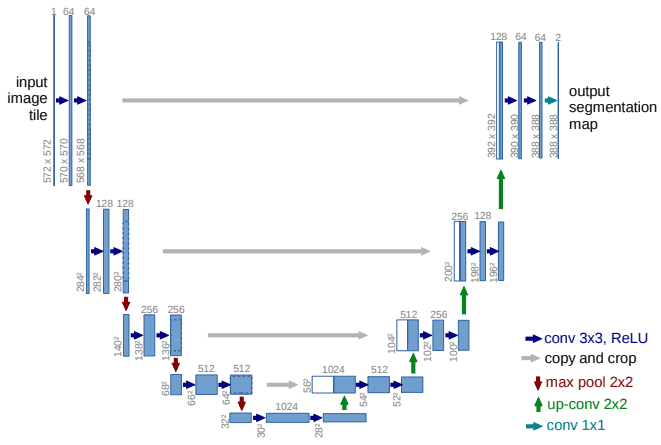

# Image segmentation with U-net
#### Author: Dominik Lau

Here's the architecture, it consists of an encoder (left) and a decoder (right). Up-conv can be implemented through:
-  deconvolution layers (trainable upsampling)
- upsampling layers (non-trainable, just interpolation, faster training & inference, but possibly worse results)


We'll use the latter one.


(Note: relation between upsampling and deconvolution is like between pooling and convolution)

(Note2: I recommend running it on colab/some beefy gpu - training and inference take a lot)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.utils as vutils

IMG_SIZE=32
BATCH_SIZE=100

# Model


First, let's deal with the double convolutions and downsampling present in each level of the u-net. It's two stacked convolutions with relus:

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


Now for the upsampling layer of the decoder and it's level



In [ ]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

We're ready to create our u-net.

(Note: out_channels is equal to the number of classes, it will represent the logits of the classes)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


# Loading data


Sneak peek at the dataset

In [ ]:
data = torchvision.datasets.OxfordIIITPet(root=".", download=True)

100%|██████████| 791918971/791918971 [00:26<00:00, 29338384.07it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16281965.35it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


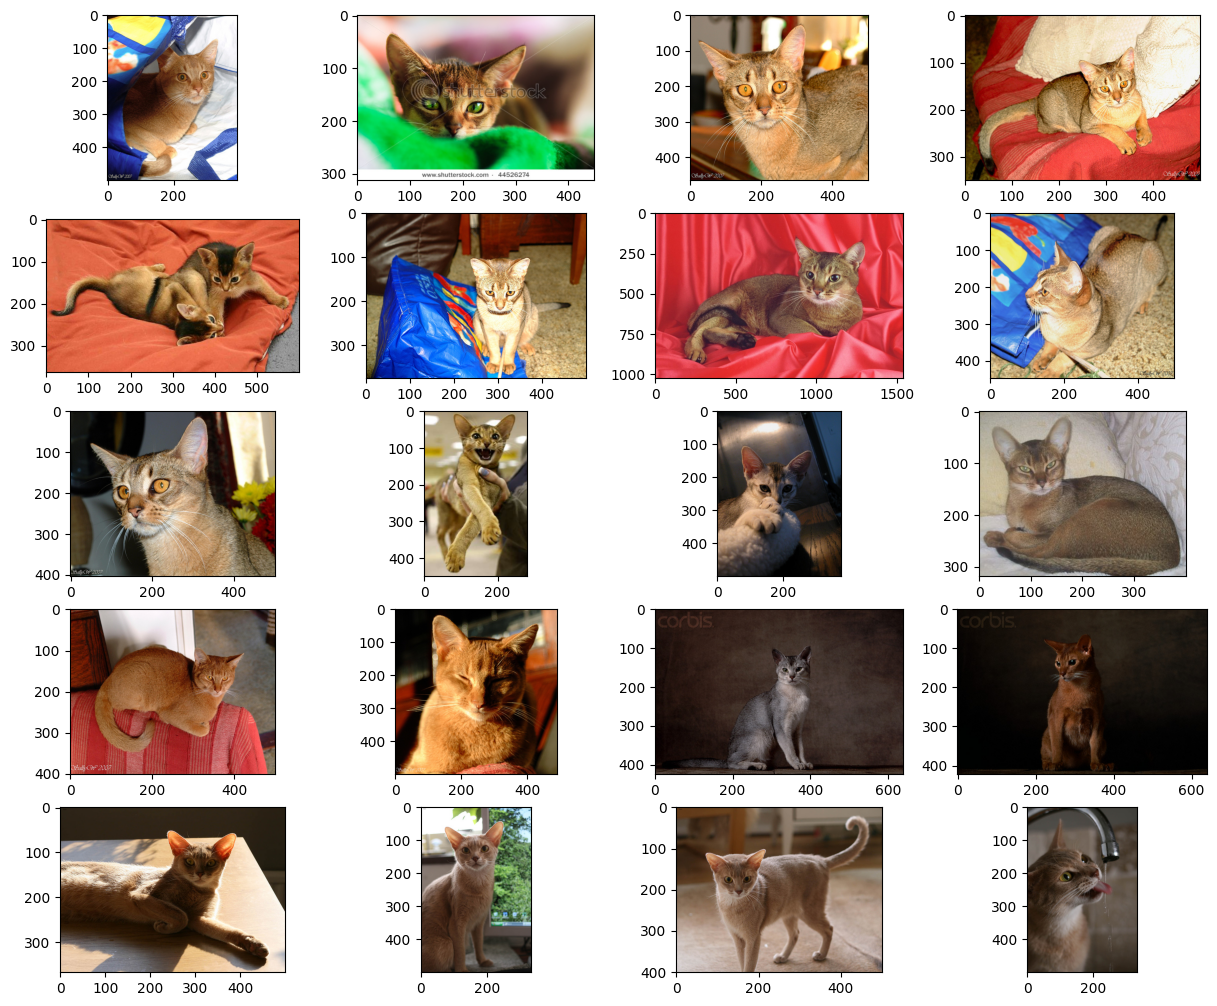

In [ ]:
def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

show_images(data)


Cats... yes, now let's load them in batches:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0.

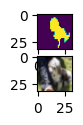

In [ ]:
class ThresholdTransform(object):
  def __init__(self, thr):
    self.thr = thr

  def __call__(self, x):
    return (x <= self.thr).to(x.dtype)

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    target_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        ThresholdTransform(thr=0.0078)
    ]

    target_transform = transforms.Compose(target_transforms)

    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.OxfordIIITPet(root=".", download=True,
                                         transform=data_transform, target_transform=target_transform,target_types='segmentation')

    sample = next(iter(train))
    print(sample[1])
    return train

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]

    img = image.detach()
    plt.imshow(reverse_transforms(img))

def show_annotated(image, channel):
    img = image.detach().cpu().numpy()
    if len(img.shape) == 4:
        img = img[0, :, :, :]
    plt.imshow(img[channel, :, :])

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

image = next(iter(dataloader))
plt.figure(figsize=(2,1))
plt.subplot(2, 1, 1)
show_tensor_image(image[1])
plt.subplot(2, 1, 2)
show_tensor_image(image[0])

print(image[1])


As you can see, it has two classes - background and foreground, hence the binarization.

The thresholding has proven to be quite useful later on in training - didn't get good results without it. You may treat it as a probability of a pixel belonging to a class $P(c_{x,y}=1 | I)$ where $I$ is our entire image, so our model will try to estimate it.

# Training

some hyperparams

In [ ]:
CLASSES = 1
NUM_EPOCHS = 30
LR = 0.01

initialize training components

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Unet(3, CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss(reduction="sum")


We'll be using simple BCE loss, but dice loss is also pretty popular in image segmentation tasks, haven't looked into it much though.

In [ ]:
sigmoid = nn.Sigmoid()

for epoch in range(NUM_EPOCHS):
    step = 0
    for batch_idx, (images_, labels_) in enumerate(dataloader):
        images = images_.to(device)
        labels = labels_.to(device)
        preds = model(images)
        preds = sigmoid(preds)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Epoc: {epoch}/{NUM_EPOCHS} | Step: {step} | Loss: {loss}')
        step += 1
#

Epoc: 0/30 | Step: 0 | Loss: 19696.02734375
Epoc: 0/30 | Step: 10 | Loss: 21878.748046875
Epoc: 0/30 | Step: 20 | Loss: 19761.41796875
Epoc: 0/30 | Step: 30 | Loss: 19599.12109375
Epoc: 1/30 | Step: 0 | Loss: 19136.53125
Epoc: 1/30 | Step: 10 | Loss: 18254.697265625
Epoc: 1/30 | Step: 20 | Loss: 18464.712890625
Epoc: 1/30 | Step: 30 | Loss: 18434.609375
Epoc: 2/30 | Step: 0 | Loss: 17247.810546875
Epoc: 2/30 | Step: 10 | Loss: 18721.775390625
Epoc: 2/30 | Step: 20 | Loss: 17181.876953125
Epoc: 2/30 | Step: 30 | Loss: 17871.224609375
Epoc: 3/30 | Step: 0 | Loss: 17244.1875
Epoc: 3/30 | Step: 10 | Loss: 17130.271484375
Epoc: 3/30 | Step: 20 | Loss: 15881.7822265625
Epoc: 3/30 | Step: 30 | Loss: 19472.80078125
Epoc: 4/30 | Step: 0 | Loss: 16891.6640625
Epoc: 4/30 | Step: 10 | Loss: 16346.134765625


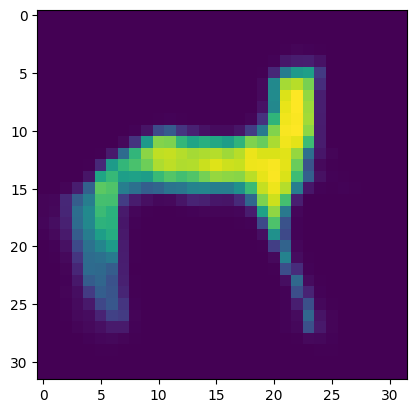

In [ ]:
plt.imshow(preds[4].cpu().detach().squeeze())

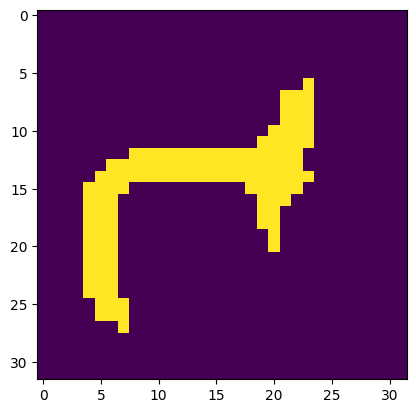

In [ ]:
plt.imshow(labels[4].cpu().detach()[0,:,:])

example output (the last batch)

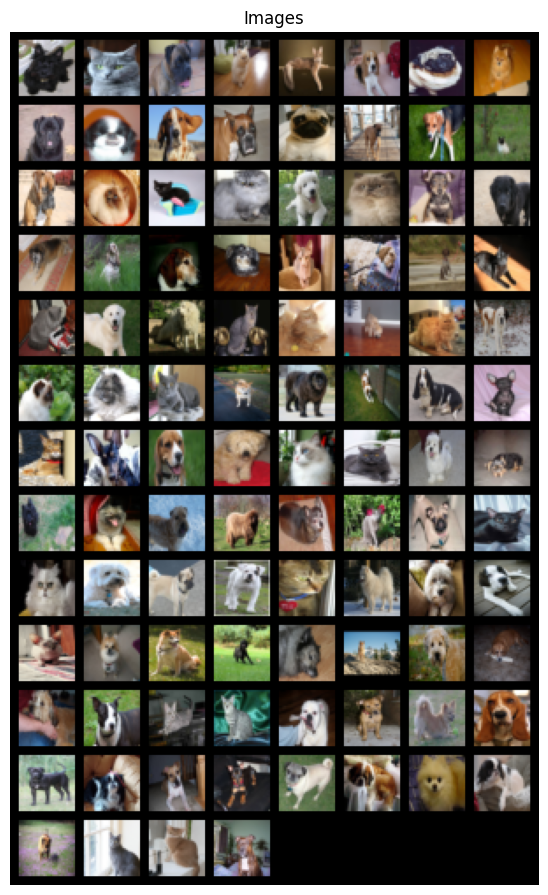

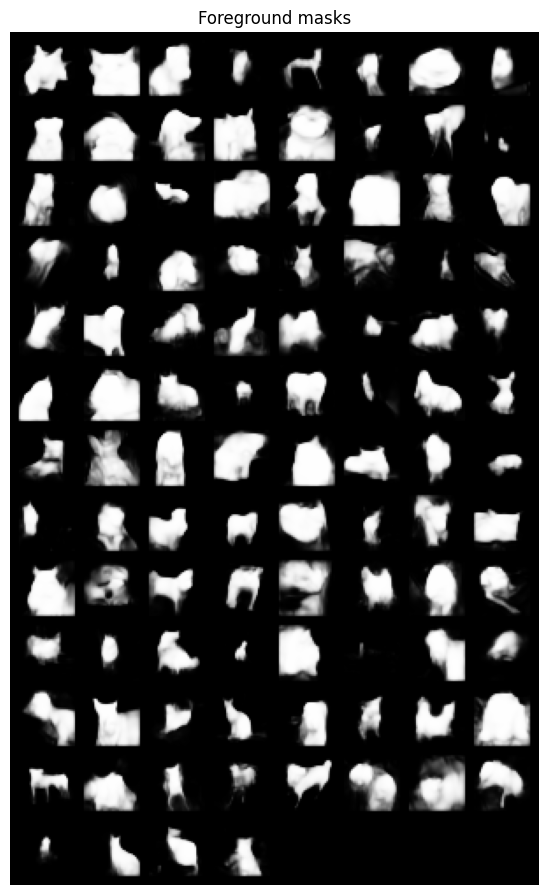

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(vutils.make_grid(images.to(device), padding=5, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Foreground masks")
plt.imshow(np.transpose(vutils.make_grid(preds.to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# References
- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://theaisummer.com/unet-architectures/
- https://github.com/Mostafa-wael/U-Net-in-PyTorch/